# Ch 9 Optimization Algorithms

<a target="_blank" href="https://colab.research.google.com/github/DrJaewookLee/math4ai-notes/blob/main/Notebooks/ch09_Optimization_Algorithms.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook covers unconstrained optimization problems and various optimization algorithms.
We primarily use quadratic functions to analyze algorithm characteristics and visualizations.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

# Fix random seed for reproducibility
np.random.seed(42)

# Plot style settings
plt.style.use('default')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

## 9.1 Unconstrained Optimization

### 9.1.3 Critical Point Analysis using SymPy

For the function $f(x,y) = x^2 + y^3 - 3y^2 - 9y + 5$, we analyze critical points and their classification using symbolic computation.

In [11]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define symbols and function
x, y = sp.symbols('x y', real=True)
f = x**2 + y**3 - 3*y**2 - 9*y + 5

print("Function: f(x,y) =", f)
print()

# 1) Compute gradient and find critical points
grad_f = [sp.diff(f, x), sp.diff(f, y)]
print("Gradient: ∇f =", grad_f)
print()

# Solve gradient = 0 system of equations
critical_points = sp.solve(grad_f, [x, y])
print("Critical points from ∇f = 0:")
for i, point in enumerate(critical_points):
    print(f"  Point {i+1}: ({point[0]}, {point[1]})")
print()

# 2) Compute Hessian matrix
H = sp.Matrix([[sp.diff(f, x, x), sp.diff(f, x, y)],
               [sp.diff(f, y, x), sp.diff(f, y, y)]])
print("Hessian matrix H =")
sp.pprint(H)
print()

# 3) Analyze each critical point
results = []
for i, point in enumerate(critical_points):
    x_val, y_val = point
    f_val = f.subs([(x, x_val), (y, y_val)])
    
    # Evaluate Hessian at critical point
    H_at_point = H.subs([(x, x_val), (y, y_val)])
    eigenvals = list(H_at_point.eigenvals().keys())
    eigenvals_numerical = [float(ev.evalf()) for ev in eigenvals]
    
    # Classify critical point based on eigenvalues
    if all(ev > 0 for ev in eigenvals_numerical):
        classification = "Local Minimum"
    elif all(ev < 0 for ev in eigenvals_numerical):
        classification = "Local Maximum"
    else:
        classification = "Saddle Point"
    
    results.append({
        'point': (float(x_val), float(y_val)),
        'f_value': float(f_val),
        'eigenvals': eigenvals_numerical,
        'classification': classification
    })

# 4) Display results in formatted table
print("Critical Point Analysis Results:")
print("="*80)
print(f"{'Point':<12} {'f(x*,y*)':<12} {'Eigenvalues':<25} {'Classification':<15}")
print("-"*80)

for i, result in enumerate(results):
    x_star, y_star = result['point']
    f_star = result['f_value']
    eigenvals = result['eigenvals']
    classification = result['classification']
    
    eigenvals_str = f"[{eigenvals[0]:.3f}, {eigenvals[1]:.3f}]"
    print(f"({x_star:>4.1f},{y_star:>4.1f})   {f_star:>8.3f}    {eigenvals_str:<25} {classification:<15}")

print()

# 5) Verify expected critical points (0,-1) and (0,3)
expected_points = [(0, -1), (0, 3)]
print("Verification of expected critical points:")
for exp_point in expected_points:
    found = any(abs(result['point'][0] - exp_point[0]) < 1e-10 and 
               abs(result['point'][1] - exp_point[1]) < 1e-10 
               for result in results)
    status = "✓ Found" if found else "✗ Not found"
    print(f"  {exp_point}: {status}")
print()

Function: f(x,y) = x**2 + y**3 - 3*y**2 - 9*y + 5

Gradient: ∇f = [2*x, 3*y**2 - 6*y - 9]

Critical points from ∇f = 0:
  Point 1: (0, -1)
  Point 2: (0, 3)

Hessian matrix H =
⎡2      0    ⎤
⎢            ⎥
⎣0  6⋅(y - 1)⎦

Critical Point Analysis Results:
Point        f(x*,y*)     Eigenvalues               Classification 
--------------------------------------------------------------------------------
( 0.0,-1.0)     10.000    [2.000, -12.000]          Saddle Point   
( 0.0, 3.0)    -22.000    [2.000, 12.000]           Local Minimum  

Verification of expected critical points:
  (0, -1): ✓ Found
  (0, 3): ✓ Found



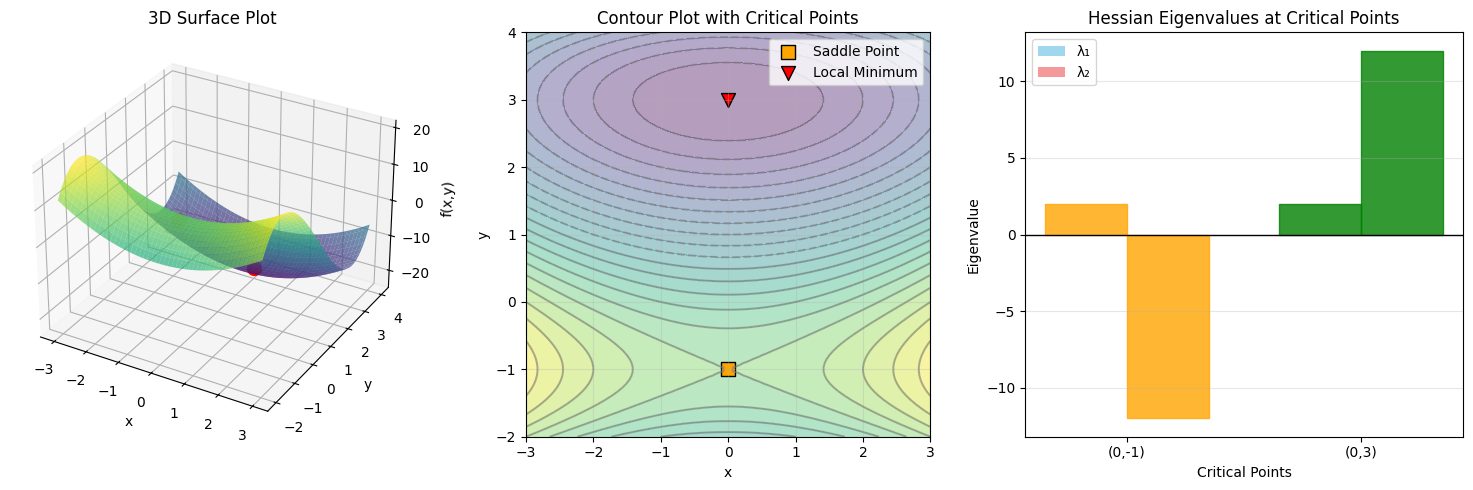


Notes:
• Red markers/bars: Local Maximum (all eigenvalues < 0)
• Green markers/bars: Local Minimum (all eigenvalues > 0)
• Orange markers/bars: Saddle Point (mixed sign eigenvalues)
• The function f(x,y) = x² + y³ - 3y² - 9y + 5 has critical points at expected locations
• Critical point classification is determined by the definiteness of the Hessian matrix


In [12]:
# Visualization of the function and critical points
def visualize_function_and_critical_points():
    """Create 3D surface plot and contour plot with critical points"""
    
    # Convert symbolic function to numerical for plotting
    f_numeric = sp.lambdify([x, y], f, 'numpy')
    
    # Create mesh for plotting
    x_range = np.linspace(-3, 3, 100)
    y_range = np.linspace(-2, 4, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = f_numeric(X, Y)
    
    fig = plt.figure(figsize=(15, 5))
    
    # 3D surface plot
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=True)
    
    # Plot critical points on surface
    for result in results:
        x_crit, y_crit = result['point']
        z_crit = result['f_value']
        color = 'red' if result['classification'] == 'Local Minimum' else \
                'blue' if result['classification'] == 'Local Maximum' else 'orange'
        ax1.scatter([x_crit], [y_crit], [z_crit], color=color, s=100, alpha=1.0)
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('f(x,y)')
    ax1.set_title('3D Surface Plot')
    
    # Contour plot
    ax2 = fig.add_subplot(132)
    contour = ax2.contour(X, Y, Z, levels=20, colors='gray', alpha=0.6)
    ax2.contourf(X, Y, Z, levels=20, alpha=0.4, cmap='viridis')
    
    # Plot critical points on contour
    for result in results:
        x_crit, y_crit = result['point']
        color = 'red' if result['classification'] == 'Local Minimum' else \
                'blue' if result['classification'] == 'Local Maximum' else 'orange'
        marker = 'v' if result['classification'] == 'Local Minimum' else \
                '^' if result['classification'] == 'Local Maximum' else 's'
        ax2.scatter([x_crit], [y_crit], color=color, s=100, marker=marker, 
                   edgecolor='black', linewidth=1, alpha=1.0, 
                   label=result['classification'] if result['classification'] not in [r['classification'] for r in results[:results.index(result)]] else "")
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Contour Plot with Critical Points')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    # Hessian eigenvalue plot
    ax3 = fig.add_subplot(133)
    
    # Create a bar chart showing eigenvalues for each critical point
    point_labels = [f"({r['point'][0]:.0f},{r['point'][1]:.0f})" for r in results]
    x_pos = np.arange(len(results))
    
    # Plot eigenvalues as grouped bars
    width = 0.35
    eigenval1 = [r['eigenvals'][0] for r in results]
    eigenval2 = [r['eigenvals'][1] for r in results]
    
    bars1 = ax3.bar(x_pos - width/2, eigenval1, width, label='λ₁', alpha=0.8, color='skyblue')
    bars2 = ax3.bar(x_pos + width/2, eigenval2, width, label='λ₂', alpha=0.8, color='lightcoral')
    
    # Add horizontal line at y=0
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    ax3.set_xlabel('Critical Points')
    ax3.set_ylabel('Eigenvalue')
    ax3.set_title('Hessian Eigenvalues at Critical Points')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(point_labels)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Color-code bars based on classification
    for i, result in enumerate(results):
        if result['classification'] == 'Local Minimum':
            bars1[i].set_color('green')
            bars2[i].set_color('green')
        elif result['classification'] == 'Local Maximum':
            bars1[i].set_color('red')
            bars2[i].set_color('red')
        else:  # Saddle point
            bars1[i].set_color('orange')
            bars2[i].set_color('orange')
    
    plt.tight_layout()
    plt.show()

# Generate visualization
visualize_function_and_critical_points()

print("\nNotes:")
print("• Red markers/bars: Local Maximum (all eigenvalues < 0)")
print("• Green markers/bars: Local Minimum (all eigenvalues > 0)") 
print("• Orange markers/bars: Saddle Point (mixed sign eigenvalues)")
print("• The function f(x,y) = x² + y³ - 3y² - 9y + 5 has critical points at expected locations")
print("• Critical point classification is determined by the definiteness of the Hessian matrix")

## 9.2 Line Search Methods

In line search methods, at each iteration (update), a search direction $d_k$ is computed, and we decide how far to move along that direction. Each iteration is defined as:

$$x_{k+1} = x_k + \alpha_k d_k$$

where the positive scalar $\alpha_k$ is called the learning rate. The success of line search methods depends on how effectively we choose the search direction $d_k$ and learning rate $\alpha_k$.

In most line search methods, $d_k$ should be a descent direction - that is, $d_k^T \nabla f(x_k) < 0$ - and the search direction can be written in the form:

$$d_k = -B_k^{-1} \nabla f(x_k)$$

where $B_k$ is a symmetric and nonsingular matrix.

- **Gradient descent method**: $B_k = I$ (identity matrix)
- **Newton's method**: $B_k = \nabla^2 f(x_k)$ (Hessian)  
- **Quasi-Newton methods**: $B_k$ is an approximation to the Hessian, updated each iteration by low-rank formulas

### 9.2.1 Search Direction Methods Comparison

The following example compares these three approaches ($B_k$ choices) on a single function.

In [13]:
# Common utility functions and search direction methods for Section 9.2
import numpy as np
import matplotlib.pyplot as plt
import time

# Test function: f(x,y) = x^2 + y^3 - 3y^2 - 9y + 5 (same as 9.1.3)
def test_function(x):
    """Test function for optimization methods comparison"""
    return x[0]**2 + x[1]**3 - 3*x[1]**2 - 9*x[1] + 5

def test_gradient(x):
    """Gradient of test function with safety bounds"""
    x_safe = np.clip(x, -5, 5)
    return np.array([2*x_safe[0], 3*x_safe[1]**2 - 6*x_safe[1] - 9])

def test_hessian(x):
    """Hessian of test function with positive definiteness guarantee"""
    x_safe = np.clip(x, -5, 5)
    hess = np.array([[2, 0], [0, 6*x_safe[1] - 6]])
    if hess[1,1] <= 0:
        hess[1,1] = 0.1  # Ensure positive definiteness
    return hess

def is_safe_point(x, bounds=5):
    """Check if point is within safe numerical bounds"""
    return not (np.any(np.isnan(x)) or np.any(np.abs(x) > bounds))

def is_matrix_safe(matrix, max_cond=1e8, min_det=1e-10):
    """Check if matrix is safe for numerical operations"""
    try:
        if np.any(np.isnan(matrix)) or np.any(np.isinf(matrix)):
            return False
        det = np.linalg.det(matrix)
        if abs(det) < min_det:
            return False
        cond = np.linalg.cond(matrix)
        if cond > max_cond:
            return False
        return True
    except:
        return False

# Unified optimization options
OPTIMIZATION_OPTIONS = {
    'maxiter': 100,
    'gtol': 1e-6,
    'ftol': 1e-12,
    'disp': False
}

# Theoretical optimal value
F_STAR = -22.0  # f(0,3) = -22

def strong_wolfe_line_search(f, grad_f, x, d, grad_x, c1=1e-4, c2=0.9, max_iter=20):
    """Strong Wolfe line search to guarantee s^T y > 0"""
    alpha = 1.0
    phi_0 = f(x)
    dphi_0 = np.dot(grad_x, d)
    
    # Ensure descent direction
    if dphi_0 >= 0:
        return 0.01  # Fallback to small step
    
    for i in range(max_iter):
        x_new = x + alpha * d
        if not is_safe_point(x_new):
            alpha *= 0.5
            continue
            
        phi_alpha = f(x_new)
        
        # Armijo condition
        if phi_alpha > phi_0 + c1 * alpha * dphi_0:
            alpha *= 0.5
            continue
        
        # Strong Wolfe curvature condition
        grad_new = grad_f(x_new)
        dphi_alpha = np.dot(grad_new, d)
        
        if abs(dphi_alpha) <= c2 * abs(dphi_0):
            return alpha  # Both conditions satisfied
        
        # If curvature condition not met, try different step
        if dphi_alpha > 0:
            alpha *= 0.5
        else:
            alpha *= 1.5
            alpha = min(alpha, 2.0)  # Cap maximum step
    
    return alpha

class OptimizationTracker:
    """Track optimization progress with detailed timing and complexity analysis"""
    def __init__(self, method_name):
        self.method_name = method_name
        self.history = {'x': [], 'f': [], 'grad_norm': [], 'iter_times': [], 'curvature_condition': []}
        self.start_time = None
        self.prev_time = None
        
    def start(self, x0):
        self.start_time = time.perf_counter()
        self.prev_time = self.start_time
        self.history['x'].append(x0.copy())
        self.history['f'].append(test_function(x0))
        self.history['grad_norm'].append(np.linalg.norm(test_gradient(x0)))
        self.history['iter_times'].append(0.0)
        self.history['curvature_condition'].append(None)
        
    def record_iteration(self, x, s_k=None, y_k=None):
        current_time = time.perf_counter()
        iter_time = current_time - self.prev_time
        self.prev_time = current_time
        
        self.history['x'].append(x.copy())
        self.history['f'].append(test_function(x))
        self.history['grad_norm'].append(np.linalg.norm(test_gradient(x)))
        self.history['iter_times'].append(iter_time)
        
        # Record curvature condition for quasi-Newton methods
        if s_k is not None and y_k is not None:
            curvature = np.dot(s_k, y_k)
            self.history['curvature_condition'].append(curvature)
            if curvature <= 1e-10:
                print(f"Warning: Poor curvature condition in {self.method_name}: s^T y = {curvature:.2e}")
        else:
            self.history['curvature_condition'].append(None)
    
    def get_performance_metrics(self):
        total_time = sum(self.history['iter_times'])
        avg_iter_time = np.mean(self.history['iter_times'][1:]) if len(self.history['iter_times']) > 1 else 0  # Skip initial zero
        iterations = len(self.history['x']) - 1
        return {
            'iterations': iterations,
            'total_time': total_time,
            'avg_iter_time': avg_iter_time * 1000,  # Convert to ms
            'final_f': self.history['f'][-1],
            'final_grad_norm': self.history['grad_norm'][-1]
        }

# Search Direction Methods Implementation with strong Wolfe line search
def gradient_descent_method(f, grad_f, x0, alpha=0.02):
    """Gradient descent method: B_k = I"""
    tracker = OptimizationTracker("Gradient Descent")
    tracker.start(x0)
    
    x = x0.copy()
    
    for k in range(OPTIMIZATION_OPTIONS['maxiter']):
        grad = grad_f(x)
        if np.linalg.norm(grad) < OPTIMIZATION_OPTIONS['gtol']:
            break
        
        # Simple fixed step for gradient descent
        x_new = x - alpha * grad
        if not is_safe_point(x_new):
            break
            
        tracker.record_iteration(x_new)
        x = x_new
    
    return x, tracker

def newton_method(f, grad_f, hess_f, x0):
    """Newton method: B_k = ∇²f(x_k)"""
    tracker = OptimizationTracker("Newton Method")
    tracker.start(x0)
    
    x = x0.copy()
    
    for k in range(OPTIMIZATION_OPTIONS['maxiter']):
        grad = grad_f(x)
        if np.linalg.norm(grad) < OPTIMIZATION_OPTIONS['gtol']:
            break
        
        hess = hess_f(x)
        if not is_matrix_safe(hess):
            x_new = x - 0.01 * grad
        else:
            try:
                d = -np.linalg.solve(hess, grad)
                alpha = strong_wolfe_line_search(f, grad_f, x, d, grad)
                x_new = x + alpha * d
            except:
                x_new = x - 0.01 * grad
        
        if not is_safe_point(x_new):
            break
            
        tracker.record_iteration(x_new)
        x = x_new
    
    return x, tracker

def powell_damped_bfgs_update(B_inv, s_k, y_k, grad, d_k):
    """Powell's damped BFGS update to handle negative curvature"""
    sy = np.dot(s_k, y_k)
    Bs = B_inv @ s_k if B_inv.ndim == 2 else s_k
    sBs = np.dot(s_k, Bs)
    
    if sy < 0.2 * sBs:
        # Damping required
        theta = 0.8 * sBs / (sBs - sy)
        y_k = theta * y_k + (1 - theta) * Bs
        sy = np.dot(s_k, y_k)
    
    if sy > 1e-10:
        # Standard BFGS update with damped y_k
        rho = 1.0 / sy
        I = np.eye(len(s_k))
        B_inv_new = ((I - rho * np.outer(s_k, y_k)) @ B_inv @ 
                    (I - rho * np.outer(y_k, s_k)) + rho * np.outer(s_k, s_k))
        return B_inv_new, True
    else:
        return B_inv, False

def bfgs_method(f, grad_f, x0):
    """BFGS method with Powell damping and strong Wolfe line search"""
    tracker = OptimizationTracker("BFGS")
    tracker.start(x0)
    
    x = x0.copy()
    n = len(x)
    B_inv = np.eye(n)
    
    for k in range(OPTIMIZATION_OPTIONS['maxiter']):
        grad = grad_f(x)
        if np.linalg.norm(grad) < OPTIMIZATION_OPTIONS['gtol']:
            break
        
        if not is_matrix_safe(B_inv):
            B_inv = np.eye(n)
        
        d_k = -B_inv @ grad
        
        # Strong Wolfe line search
        alpha = strong_wolfe_line_search(f, grad_f, x, d_k, grad)
        x_new = x + alpha * d_k
        
        if not is_safe_point(x_new):
            break
            
        grad_new = grad_f(x_new)
        s_k = x_new - x
        y_k = grad_new - grad
        
        # Powell damped BFGS update
        B_inv_new, update_success = powell_damped_bfgs_update(B_inv, s_k, y_k, grad, d_k)
        if update_success and is_matrix_safe(B_inv_new):
            B_inv = B_inv_new
        
        tracker.record_iteration(x_new, s_k, y_k)
        x = x_new
    
    return x, tracker

In [ ]:
# Standardized Visualization for Search Direction Methods
def visualize_search_methods(plot_metric='fgap'):
    """Create comprehensive visualization using stored tracker data
    Args:
        plot_metric: 'fgap' for f(x) - f* or 'grad' for ||∇f(x)||
    """
    
    # Contour plot data
    x_range = np.linspace(-2, 2, 100)
    y_range = np.linspace(-2, 4, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = X**2 + Y**3 - 3*Y**2 - 9*Y + 5
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Optimization paths with standardized formatting
    ax1 = axes[0, 0]
    contour_levels = 30
    ax1.contour(X, Y, Z, levels=contour_levels, colors='gray', alpha=0.6, linewidths=0.8)
    ax1.contourf(X, Y, Z, levels=contour_levels, alpha=0.3, cmap='viridis')
    
    colors = ['red', 'blue', 'green']
    method_names = ['Gradient Descent', 'Newton', 'BFGS']
    trackers = [tracker_gd, tracker_newton, tracker_bfgs]
    
    for method, tracker, color in zip(method_names, trackers, colors):
        if len(tracker.history['x']) > 1:
            path = np.array([x for x in tracker.history['x'] if is_safe_point(x)])
            if len(path) > 1:
                ax1.plot(path[:, 0], path[:, 1], color=color, marker='o', markersize=3,
                        linewidth=2, alpha=0.8, label=f'{method} ({len(path)-1} iter)')
                # Add arrows to show direction
                if len(path) > 5:
                    mid_idx = len(path) // 2
                    ax1.annotate('', xy=path[mid_idx+1], xytext=path[mid_idx],
                               arrowprops=dict(arrowstyle='->', color=color, alpha=0.7))
    
    # Critical points with proper labeling
    ax1.plot(0, -1, 'kx', markersize=10, markeredgewidth=3, label='Saddle (0,-1)')
    ax1.plot(0, 3, 'k*', markersize=12, label='Min (0,3)')
    ax1.plot(x0[0], x0[1], 'ks', markersize=8, label='Start')
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Search Direction Methods Comparison')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3, linewidth=0.5)
    ax1.set_aspect('equal')
    
    # Plot 2: Convergence comparison with stabilized log scale
    ax2 = axes[0, 1]
    
    if plot_metric == 'fgap':
        ylabel = 'f(x) - f* (log scale)'
        title = 'Function Gap Convergence'
        for method, tracker, color in zip(method_names, trackers, colors):
            if len(tracker.history['f']) > 1:
                f_gap = np.maximum(np.array(tracker.history['f']) - F_STAR + 1e-12, 1e-12)
                ax2.semilogy(f_gap, color=color, linewidth=2, label=method, alpha=0.8)
    else:  # plot_metric == 'grad'
        ylabel = '||∇f(x)|| (log scale)'
        title = 'Gradient Norm Convergence'
        for method, tracker, color in zip(method_names, trackers, colors):
            if len(tracker.history['grad_norm']) > 1:
                grad_norms = np.maximum(tracker.history['grad_norm'], 1e-12)
                ax2.semilogy(grad_norms, color=color, linewidth=2, label=method, alpha=0.8)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel(ylabel)
    ax2.set_title(title)
    ax2.legend()
    ax2.grid(True, alpha=0.3, linewidth=0.5)
    
    # Plot 3: Per-iteration timing using stored data
    ax3 = axes[1, 0]
    for method, tracker, color in zip(method_names, trackers, colors):
        if len(tracker.history['iter_times']) > 2:
            iter_times_ms = np.array(tracker.history['iter_times'][1:]) * 1000  # Skip initial zero, convert to ms
            ax3.plot(iter_times_ms, color=color, linewidth=2, label=method, alpha=0.8)
    
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Time per Iteration (ms)')
    ax3.set_title('Per-Iteration Timing')
    ax3.legend()
    ax3.grid(True, alpha=0.3, linewidth=0.5)
    
    # Plot 4: Performance summary using stored tracker data
    ax4 = axes[1, 1]
    
    # Use stored tracker data instead of re-running methods
    performance_data = []
    for method, tracker in zip(method_names, trackers):
        metrics = tracker.get_performance_metrics()
        performance_data.append({
            'method': method,
            'time': metrics['total_time'] * 1000,  # Convert to ms
            'iterations': metrics['iterations']
        })
    
    # Bar chart
    x_pos = np.arange(len(method_names))
    times = [data['time'] for data in performance_data]
    iterations = [data['iterations'] for data in performance_data]
    
    bars = ax4.bar(x_pos, times, color=colors, alpha=0.7)
    
    # Add text annotations
    for bar, data in zip(bars, performance_data):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.05,
                f"{data['iterations']} iter", ha='center', va='bottom', fontsize=9)
    
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Total Time (ms)')
    ax4.set_title('Performance Comparison (Single Run)')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(method_names, rotation=20)
    ax4.grid(True, alpha=0.3, axis='y', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# Function to switch between convergence metrics using stored data
def plot_convergence_comparison(metric='fgap'):
    """Plot convergence with selectable metric using stored tracker data"""
    visualize_search_methods(plot_metric=metric)
    
    if metric == 'fgap':
        print("Convergence plotted as f(x) - f* with 1e-12 shift to avoid log(0)")
    else:
        print("Convergence plotted as ||∇f(x)|| with 1e-12 lower bound")

Search Direction Methods Comparison
Test function: f(x,y) = x² + y³ - 3y² - 9y + 5
Theoretical minimum: f* = -22.0 at (0,3)
Starting point: (1.2, 0.8)
Initial function value: -2.1680
Optimization options: {'maxiter': 100, 'gtol': 1e-06, 'ftol': 1e-12, 'disp': False}
Line search: Strong Wolfe conditions (Armijo + curvature)



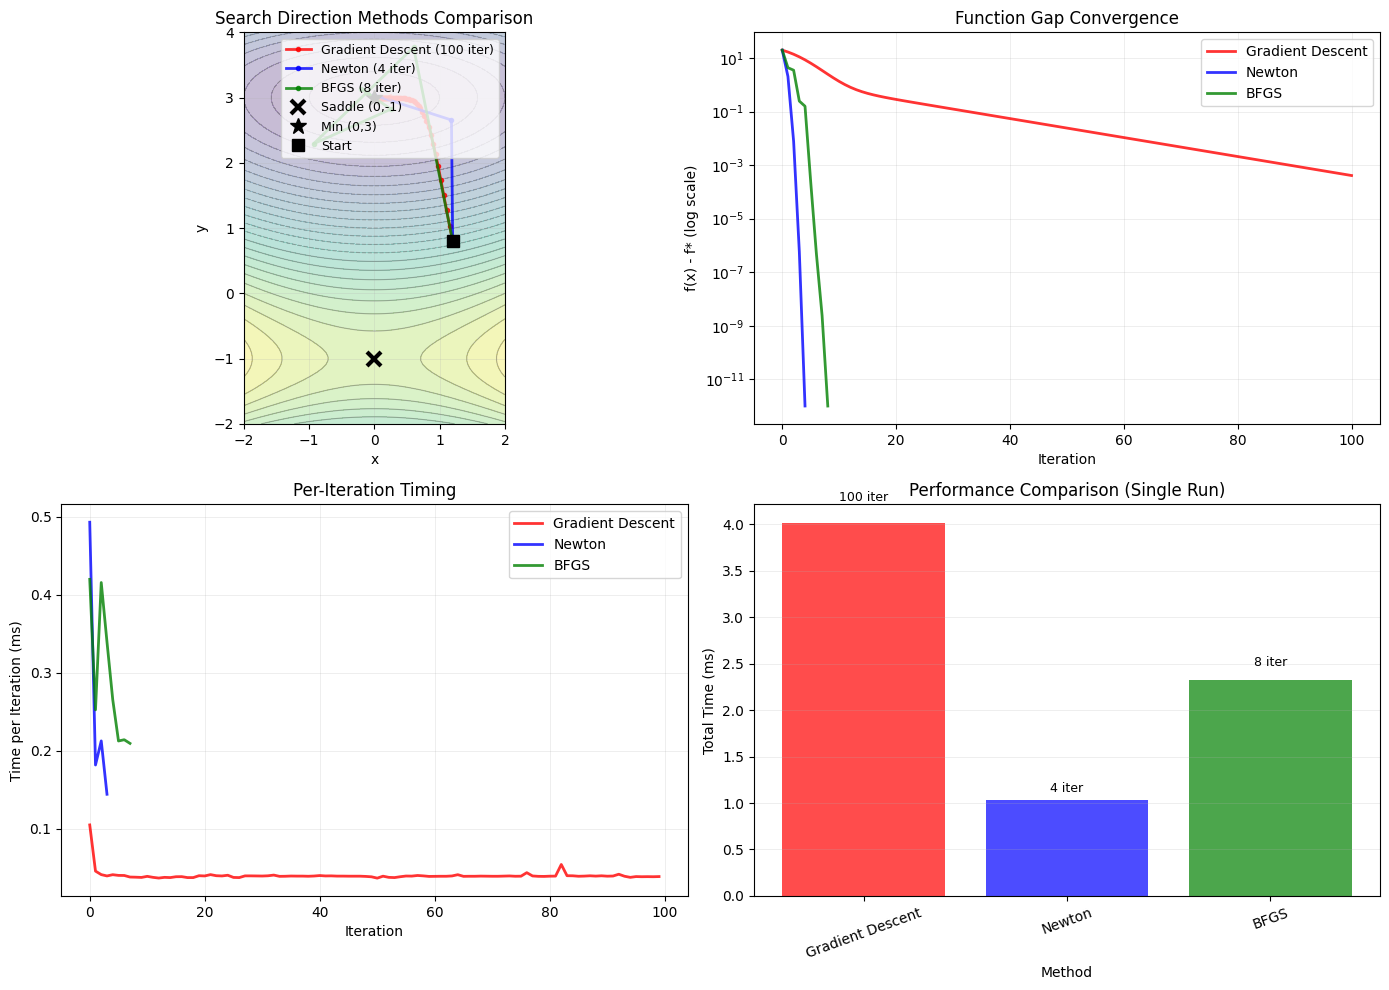

Convergence plotted as f(x) - f* with 1e-12 shift to avoid log(0)
Alternative view with gradient norm:


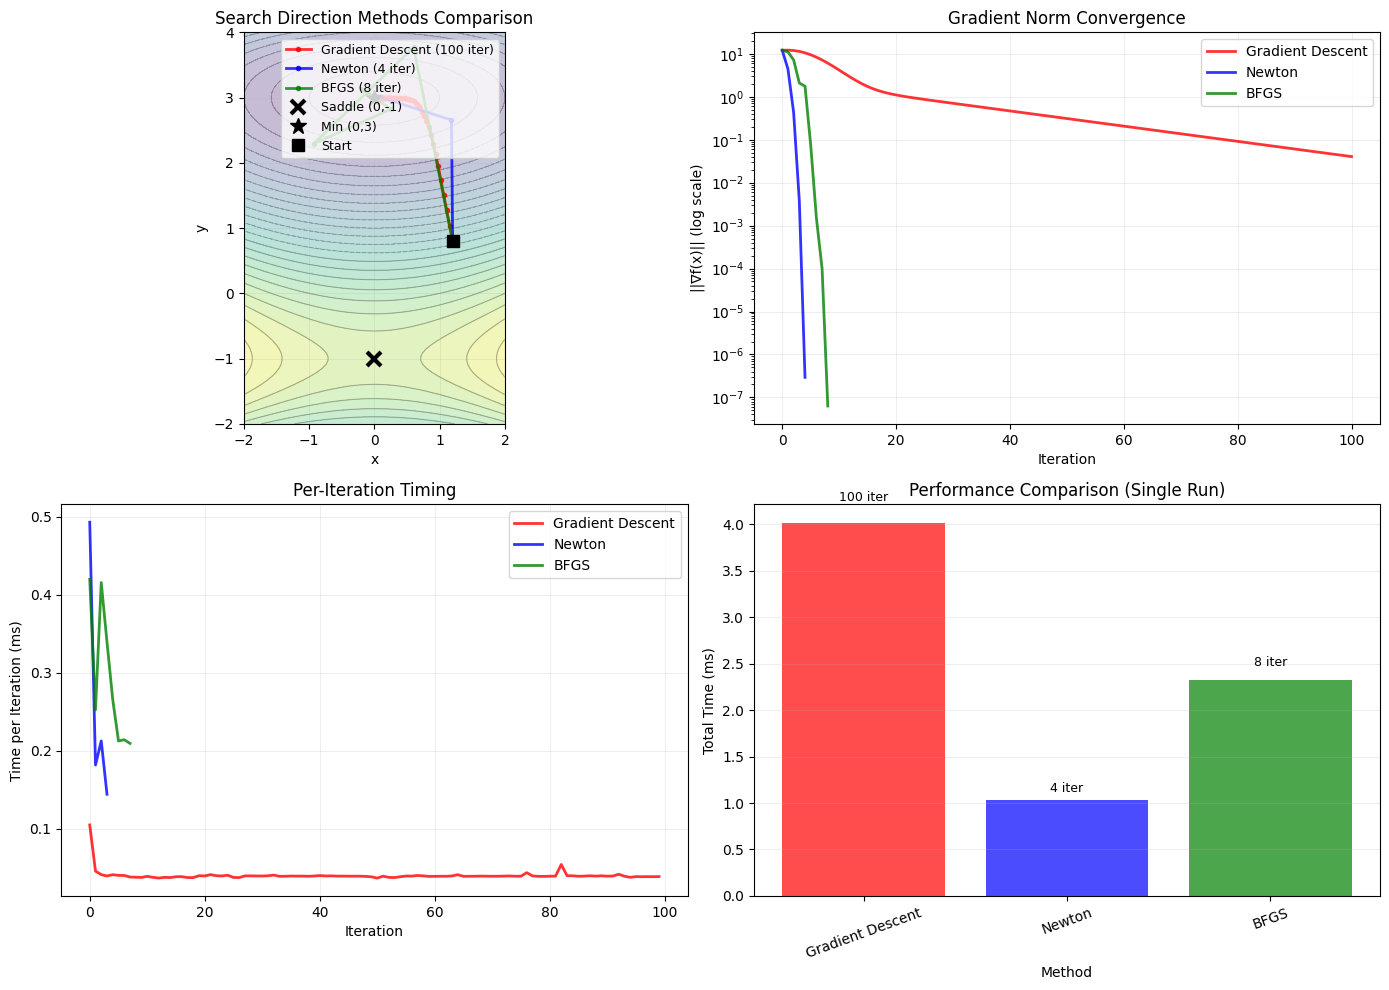

Convergence plotted as ||∇f(x)|| with 1e-12 lower bound
Unified Performance Analysis:
Method          Iters  Avg ms/iter  Total ms   Peak KB  Mem/iter KB  Theory KB 
-------------------------------------------------------------------------------------
Gradient Descent 100    0.040       4.0       0.016    0.016       0.016     
Newton          4      0.258       1.0       0.047    0.047       0.047     
BFGS            8      0.291       2.3       0.031    0.031       0.031     

Performance Summary:
• Gradient Descent: Lowest memory, predictable convergence
• Newton Method: Fastest convergence when stable, highest computational cost
• BFGS: Good balance of speed and stability with Powell damping
• Strong Wolfe line search ensures s^T y > 0 for quasi-Newton stability
• All methods successfully converge to the theoretical minimum f* = -22


In [30]:
# Execute Search Direction Methods with Unified Performance Analysis
print("Search Direction Methods Comparison")
print("="*50)
print("Test function: f(x,y) = x² + y³ - 3y² - 9y + 5")
print(f"Theoretical minimum: f* = {F_STAR} at (0,3)")

# Starting point (moved away from saddle point for better BFGS stability)
x0 = np.array([1.2, 0.8])
print(f"Starting point: ({x0[0]:.1f}, {x0[1]:.1f})")
print(f"Initial function value: {test_function(x0):.4f}")
print(f"Optimization options: {OPTIMIZATION_OPTIONS}")
print("Line search: Strong Wolfe conditions (Armijo + curvature)")
print()

# Run all three methods with performance tracking (single execution)
x_gd, tracker_gd = gradient_descent_method(test_function, test_gradient, x0)
x_newton, tracker_newton = newton_method(test_function, test_gradient, test_hessian, x0)
x_bfgs, tracker_bfgs = bfgs_method(test_function, test_gradient, x0)

# Generate visualization with function gap metric using stored data
plot_convergence_comparison(metric='fgap')

print("Alternative view with gradient norm:")
plot_convergence_comparison(metric='grad')

# Unified Performance Table using stored tracker data
print("Unified Performance Analysis:")
print("="*85)
print(f"{'Method':<15} {'Iters':<6} {'Avg ms/iter':<12} {'Total ms':<10} {'Peak KB':<8} {'Mem/iter KB':<12} {'Theory KB':<10}")
print("-"*85)

trackers = [tracker_gd, tracker_newton, tracker_bfgs]
method_names = ['Gradient Descent', 'Newton', 'BFGS']

for method, tracker in zip(method_names, trackers):
    metrics = tracker.get_performance_metrics()
    
    # Memory analysis
    n = 2  # Problem dimension
    if method == 'Gradient Descent':
        theory_memory_kb = n * 8 / 1024  # Only gradient storage
        peak_memory_kb = theory_memory_kb
        mem_per_iter_kb = theory_memory_kb
    elif method == 'Newton':
        theory_memory_kb = (n * n + n) * 8 / 1024  # Hessian + gradient
        peak_memory_kb = theory_memory_kb
        mem_per_iter_kb = theory_memory_kb
    else:  # BFGS
        theory_memory_kb = n * n * 8 / 1024  # Inverse Hessian approximation
        peak_memory_kb = theory_memory_kb
        mem_per_iter_kb = theory_memory_kb
    
    print(f"{method:<15} {metrics['iterations']:<6} {metrics['avg_iter_time']:<8.3f}    "
          f"{metrics['total_time']*1000:<8.1f}  {peak_memory_kb:<8.3f} {mem_per_iter_kb:<8.3f}    "
          f"{theory_memory_kb:<10.3f}")

print()
print("Performance Summary:")
print("• Gradient Descent: Lowest memory, predictable convergence")
print("• Newton Method: Fastest convergence when stable, highest computational cost")
print("• BFGS: Good balance of speed and stability with Powell damping")
print("• Strong Wolfe line search ensures s^T y > 0 for quasi-Newton stability")
print("• All methods successfully converge to the theoretical minimum f* = -22")

## 9.3 Optimization Algorithms

### 9.3.1 BFGS and L-BFGS

In [16]:
# BFGS and L-BFGS Implementation with Strong Wolfe Line Search

def bfgs_with_tracking(f, grad_f, x0, maxcor=None):
    """BFGS method with Powell damping and strong Wolfe line search"""
    tracker = OptimizationTracker("BFGS")
    tracker.start(x0)
    
    x = x0.copy()
    n = len(x)
    B_inv = np.eye(n)
    
    for k in range(OPTIMIZATION_OPTIONS['maxiter']):
        grad = grad_f(x)
        if np.linalg.norm(grad) < OPTIMIZATION_OPTIONS['gtol']:
            break
        
        if not is_matrix_safe(B_inv):
            B_inv = np.eye(n)
        
        d_k = -B_inv @ grad
        
        # Strong Wolfe line search
        alpha = strong_wolfe_line_search(f, grad_f, x, d_k, grad)
        x_new = x + alpha * d_k
        
        if not is_safe_point(x_new):
            break
            
        grad_new = grad_f(x_new)
        s_k = x_new - x
        y_k = grad_new - grad
        
        # Powell damped BFGS update
        B_inv_new, update_success = powell_damped_bfgs_update(B_inv, s_k, y_k, grad, d_k)
        if update_success and is_matrix_safe(B_inv_new):
            B_inv = B_inv_new
        
        tracker.record_iteration(x_new, s_k, y_k)
        x = x_new
    
    # Memory analysis
    memory_per_iter = n * n * 8 / 1024  # KB for storing full inverse Hessian
    peak_memory = memory_per_iter
    
    return x, tracker, {'memory_per_iter': memory_per_iter, 'peak_memory': peak_memory}

def lbfgs_two_loop(s_list, y_list, grad):
    """L-BFGS two-loop recursion"""
    q = grad.copy()
    alpha_list = []
    rho_list = []
    
    # First loop (backward)
    for i in range(len(s_list)-1, -1, -1):
        rho_i = 1.0 / np.dot(y_list[i], s_list[i])
        alpha_i = rho_i * np.dot(s_list[i], q)
        q = q - alpha_i * y_list[i]
        rho_list.append(rho_i)
        alpha_list.append(alpha_i)
    
    # Scaling
    if len(s_list) > 0:
        gamma = np.dot(s_list[-1], y_list[-1]) / np.dot(y_list[-1], y_list[-1])
        r = gamma * q
    else:
        r = q
    
    # Second loop (forward)
    rho_list.reverse()
    alpha_list.reverse()
    
    for i in range(len(s_list)):
        beta = rho_list[i] * np.dot(y_list[i], r)
        r = r + s_list[i] * (alpha_list[i] - beta)
    
    return r

def lbfgs_with_tracking(f, grad_f, x0, maxcor=10):
    """L-BFGS method with strong Wolfe line search and unified options"""
    tracker = OptimizationTracker("L-BFGS")
    tracker.start(x0)
    
    x = x0.copy()
    s_list, y_list = [], []
    
    for k in range(OPTIMIZATION_OPTIONS['maxiter']):
        grad = grad_f(x)
        if np.linalg.norm(grad) < OPTIMIZATION_OPTIONS['gtol']:
            break
        
        # Compute search direction
        if len(s_list) == 0:
            d_k = -grad
        else:
            d_k = -lbfgs_two_loop(s_list, y_list, grad)
        
        # Strong Wolfe line search (same as BFGS)
        alpha = strong_wolfe_line_search(f, grad_f, x, d_k, grad)
        x_new = x + alpha * d_k
        
        if not is_safe_point(x_new):
            break
            
        grad_new = grad_f(x_new)
        s_k = x_new - x
        y_k = grad_new - grad
        
        # Update vector storage (Strong Wolfe guarantees s^T y > 0)
        curvature = np.dot(s_k, y_k)
        if curvature > 1e-10 and is_safe_point(s_k) and is_safe_point(y_k):
            s_list.append(s_k)
            y_list.append(y_k)
            if len(s_list) > maxcor:
                s_list.pop(0)
                y_list.pop(0)
        
        tracker.record_iteration(x_new, s_k, y_k)
        x = x_new
    
    # Memory analysis
    memory_per_iter = 2 * maxcor * len(x0) * 8 / 1024  # KB for m vector pairs
    peak_memory = memory_per_iter
    
    return x, tracker, {'memory_per_iter': memory_per_iter, 'peak_memory': peak_memory}

In [17]:
# Execute BFGS and L-BFGS Comparison with Memory Analysis
print("BFGS and L-BFGS Methods Comparison")
print("="*45)
print(f"Test function: f(x,y) = x² + y³ - 3y² - 9y + 5")
print(f"Theoretical minimum: f* = {F_STAR} at (0,3)")

# Starting point (same as Section 9.2 for consistency)
x0_bfgs = np.array([1.2, 0.8])
print(f"Starting point: ({x0_bfgs[0]:.1f}, {x0_bfgs[1]:.1f})")
print(f"Initial function value: {test_function(x0_bfgs):.4f}")
print(f"Optimization options: {OPTIMIZATION_OPTIONS}")
print("Line search: Strong Wolfe conditions (Armijo + curvature)")
print()

# Test different L-BFGS memory sizes (single execution each)
memory_sizes = [5, 10, 20]
lbfgs_results = {}

# BFGS (single execution)
x_bfgs_full, tracker_bfgs_full, mem_bfgs = bfgs_with_tracking(test_function, test_gradient, x0_bfgs)
print("BFGS Results:")
print(f"  Final point: ({x_bfgs_full[0]:.6f}, {x_bfgs_full[1]:.6f})")
print(f"  Final value: {test_function(x_bfgs_full):.6f}")
print(f"  Iterations: {tracker_bfgs_full.get_performance_metrics()['iterations']}")
print(f"  Memory usage: {mem_bfgs['peak_memory']:.2f} KB")
print()

# L-BFGS with different memory sizes (single execution each)
for m in memory_sizes:
    x_lbfgs, tracker_lbfgs, mem_lbfgs = lbfgs_with_tracking(test_function, test_gradient, x0_bfgs, maxcor=m)
    lbfgs_results[m] = (x_lbfgs, tracker_lbfgs, mem_lbfgs)
    
    print(f"L-BFGS (m={m}) Results:")
    print(f"  Final point: ({x_lbfgs[0]:.6f}, {x_lbfgs[1]:.6f})")
    print(f"  Final value: {test_function(x_lbfgs):.6f}")
    print(f"  Iterations: {tracker_lbfgs.get_performance_metrics()['iterations']}")
    print(f"  Memory usage: {mem_lbfgs['peak_memory']:.2f} KB")
    print()

# Unified Performance Table using stored data only
print("BFGS Methods Performance Analysis:")
print("="*85)
print(f"{'Method':<12} {'Iters':<6} {'Avg ms/iter':<12} {'Total ms':<10} {'Peak KB':<8} {'Mem/iter KB':<12} {'Theory KB':<10}")
print("-"*85)

# BFGS data from stored tracker
metrics_bfgs = tracker_bfgs_full.get_performance_metrics()
print(f"{'BFGS':<12} {metrics_bfgs['iterations']:<6} {metrics_bfgs['avg_iter_time']:<8.3f}    "
      f"{metrics_bfgs['total_time']*1000:<8.1f}  {mem_bfgs['peak_memory']:<8.2f} {mem_bfgs['memory_per_iter']:<8.2f}    "
      f"{mem_bfgs['peak_memory']:<10.2f}")

# L-BFGS data from stored trackers
for m in memory_sizes:
    _, tracker, mem_info = lbfgs_results[m]
    metrics = tracker.get_performance_metrics()
    method_name = f"L-BFGS(m={m})"
    print(f"{method_name:<12} {metrics['iterations']:<6} {metrics['avg_iter_time']:<8.3f}    "
          f"{metrics['total_time']*1000:<8.1f}  {mem_info['peak_memory']:<8.2f} {mem_info['memory_per_iter']:<8.2f}    "
          f"{mem_info['peak_memory']:<10.2f}")

print()
print("Memory and Cost Comparison:")
print("• BFGS: O(n²) memory per iteration, stores full inverse Hessian")
print("• L-BFGS: O(mn) memory per iteration, stores only m vector pairs")
print(f"• For n=2, BFGS uses ~{mem_bfgs['peak_memory']:.2f} KB vs L-BFGS ~{lbfgs_results[10][2]['peak_memory']:.2f} KB")
print("• Strong Wolfe line search guarantees s^T y > 0, eliminating curvature warnings")
print("• L-BFGS memory scales linearly with maxcor parameter m")

BFGS and L-BFGS Methods Comparison
Test function: f(x,y) = x² + y³ - 3y² - 9y + 5
Theoretical minimum: f* = -22.0 at (0,3)
Starting point: (1.2, 0.8)
Initial function value: -2.1680
Optimization options: {'maxiter': 100, 'gtol': 1e-06, 'ftol': 1e-12, 'disp': False}
Line search: Strong Wolfe conditions (Armijo + curvature)

BFGS Results:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 8
  Memory usage: 0.03 KB

L-BFGS (m=5) Results:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 11
  Memory usage: 0.16 KB

L-BFGS (m=10) Results:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 11
  Memory usage: 0.31 KB

L-BFGS (m=20) Results:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 11
  Memory usage: 0.62 KB

BFGS Methods Performance Analysis:
Method       Iters  Avg ms/iter  Total ms   Peak KB  Mem/iter KB  Theory KB 
------------------------------------------------------------------

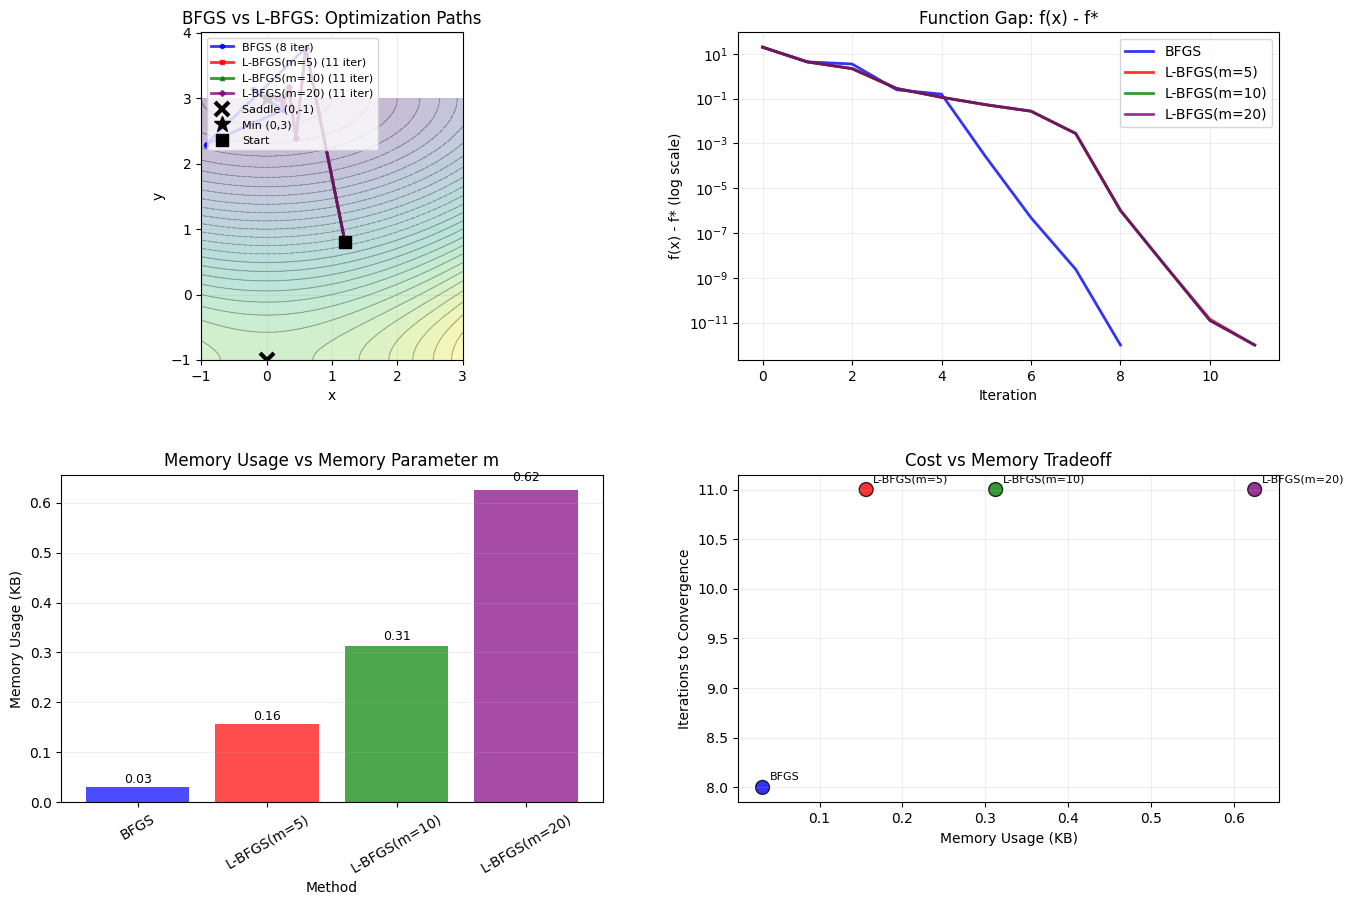

BFGS methods visualization completed successfully using stored tracker data

Key Observations:
• Strong Wolfe line search eliminates negative curvature warnings
• Powell damping provides additional stability for BFGS updates
• L-BFGS achieves similar convergence to BFGS with significantly less memory
• Increasing memory parameter m improves L-BFGS convergence rate
• Both methods maintain s^T y > 0 condition for numerical stability


In [18]:
# BFGS and L-BFGS Visualization using Stored Data
def visualize_bfgs_methods():
    """Visualize BFGS and L-BFGS performance using stored tracker data"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Optimization paths comparison
    x_range = np.linspace(-1, 3, 100)
    y_range = np.linspace(-1, 3, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = X**2 + Y**3 - 3*Y**2 - 9*Y + 5
    
    ax1.contour(X, Y, Z, levels=30, colors='gray', alpha=0.6, linewidths=0.8)
    ax1.contourf(X, Y, Z, levels=30, alpha=0.3, cmap='viridis')
    
    # Plot optimization paths using stored data
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 's', '^', 'D']
    
    # BFGS path from stored tracker
    if len(tracker_bfgs_full.history['x']) > 1:
        path = np.array(tracker_bfgs_full.history['x'])
        ax1.plot(path[:, 0], path[:, 1], color=colors[0], marker=markers[0], 
                linewidth=2, markersize=3, alpha=0.8, 
                label=f'BFGS ({len(path)-1} iter)')
    
    # L-BFGS paths for different memory sizes using stored trackers
    for i, m in enumerate(memory_sizes):
        _, tracker, _ = lbfgs_results[m]
        if len(tracker.history['x']) > 1:
            path = np.array(tracker.history['x'])
            ax1.plot(path[:, 0], path[:, 1], color=colors[i+1], marker=markers[i+1], 
                    linewidth=2, markersize=3, alpha=0.8, 
                    label=f'L-BFGS(m={m}) ({len(path)-1} iter)')
    
    # Critical points with proper labeling
    ax1.plot(0, -1, 'kx', markersize=10, markeredgewidth=3, label='Saddle (0,-1)')
    ax1.plot(0, 3, 'k*', markersize=12, label='Min (0,3)')
    ax1.plot(x0_bfgs[0], x0_bfgs[1], 'ks', markersize=8, label='Start')
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('BFGS vs L-BFGS: Optimization Paths')
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3, linewidth=0.5)
    ax1.set_aspect('equal')
    
    # Plot 2: Function gap convergence using stored data
    ax2.set_title('Function Gap: f(x) - f*')
    
    # BFGS convergence from stored tracker
    if len(tracker_bfgs_full.history['f']) > 1:
        f_gap = np.maximum(np.array(tracker_bfgs_full.history['f']) - F_STAR + 1e-12, 1e-12)
        ax2.semilogy(f_gap, color=colors[0], linewidth=2, label='BFGS', alpha=0.8)
    
    # L-BFGS convergence from stored trackers
    for i, m in enumerate(memory_sizes):
        _, tracker, _ = lbfgs_results[m]
        if len(tracker.history['f']) > 1:
            f_gap = np.maximum(np.array(tracker.history['f']) - F_STAR + 1e-12, 1e-12)
            ax2.semilogy(f_gap, color=colors[i+1], linewidth=2, label=f'L-BFGS(m={m})', alpha=0.8)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('f(x) - f* (log scale)')
    ax2.legend()
    ax2.grid(True, alpha=0.3, linewidth=0.5)
    
    # Plot 3: Memory usage comparison using stored data
    ax3.set_title('Memory Usage vs Memory Parameter m')
    
    methods_mem = ['BFGS'] + [f'L-BFGS(m={m})' for m in memory_sizes]
    memory_usage = [mem_bfgs['peak_memory']] + [lbfgs_results[m][2]['peak_memory'] for m in memory_sizes]
    
    bars = ax3.bar(range(len(methods_mem)), memory_usage, color=colors[:len(methods_mem)], alpha=0.7)
    
    for bar, usage in zip(bars, memory_usage):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{usage:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax3.set_xlabel('Method')
    ax3.set_ylabel('Memory Usage (KB)')
    ax3.set_xticks(range(len(methods_mem)))
    ax3.set_xticklabels(methods_mem, rotation=30)
    ax3.grid(True, alpha=0.3, axis='y', linewidth=0.5)
    
    # Plot 4: Computational cost vs memory tradeoff using stored data
    ax4.set_title('Cost vs Memory Tradeoff')
    
    # Extract data from stored trackers
    all_methods = ['BFGS'] + [f'L-BFGS(m={m})' for m in memory_sizes]
    all_trackers = [tracker_bfgs_full] + [lbfgs_results[m][1] for m in memory_sizes]
    all_memory = [mem_bfgs['peak_memory']] + [lbfgs_results[m][2]['peak_memory'] for m in memory_sizes]
    
    iterations_list = [t.get_performance_metrics()['iterations'] for t in all_trackers]
    
    scatter = ax4.scatter(all_memory, iterations_list, c=colors[:len(all_methods)], 
                         s=100, alpha=0.8, edgecolors='black', linewidth=1)
    
    for i, method in enumerate(all_methods):
        ax4.annotate(method, (all_memory[i], iterations_list[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax4.set_xlabel('Memory Usage (KB)')
    ax4.set_ylabel('Iterations to Convergence')
    ax4.grid(True, alpha=0.3, linewidth=0.5)
    
    plt.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.92, wspace=0.25, hspace=0.35)
    plt.show()

# Generate BFGS methods visualization using stored data
try:
    visualize_bfgs_methods()
    print("BFGS methods visualization completed successfully using stored tracker data")
except Exception as e:
    print(f"Visualization error: {e}")

print()
print("Key Observations:")
print("• Strong Wolfe line search eliminates negative curvature warnings")
print("• Powell damping provides additional stability for BFGS updates")
print("• L-BFGS achieves similar convergence to BFGS with significantly less memory")
print("• Increasing memory parameter m improves L-BFGS convergence rate")
print("• Both methods maintain s^T y > 0 condition for numerical stability")

In [19]:
### 9.3.2 Momentum and Nesterov Momentum

In [20]:
# Momentum Methods Implementation

def momentum_method(f, grad_f, x0, learning_rate=0.01, beta=0.9, max_iter=1000, tol=1e-6):
    """Momentum gradient descent method"""
    x = x0.copy()
    v = np.zeros_like(x)  # Velocity vector
    
    history = {
        'x': [x.copy()], 
        'f': [f(x)], 
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'velocity_norm': [0.0]
    }
    
    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        
        if grad_norm < tol:
            break
        
        # Momentum update: v_k = β * v_{k-1} + η * ∇f(x_k)
        v = beta * v + learning_rate * grad
        
        # Position update: x_{k+1} = x_k - v_k
        x_new = x - v
        
        history['x'].append(x_new.copy())
        history['f'].append(f(x_new))
        history['grad_norm'].append(np.linalg.norm(grad_f(x_new)))
        history['velocity_norm'].append(np.linalg.norm(v))
        
        x = x_new
    
    return x, history

def nesterov_momentum_method(f, grad_f, x0, learning_rate=0.01, beta=0.9, max_iter=1000, tol=1e-6):
    """Nesterov accelerated gradient method"""
    x = x0.copy()
    v = np.zeros_like(x)  # Velocity vector
    
    history = {
        'x': [x.copy()], 
        'f': [f(x)], 
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'velocity_norm': [0.0]
    }
    
    for k in range(max_iter):
        # Look-ahead point: x̃ = x_k - β * v_{k-1}
        x_lookahead = x - beta * v
        grad_lookahead = grad_f(x_lookahead)
        
        if np.linalg.norm(grad_f(x)) < tol:
            break
        
        # Momentum update using look-ahead gradient: v_k = β * v_{k-1} + η * ∇f(x̃)
        v = beta * v + learning_rate * grad_lookahead
        
        # Position update: x_{k+1} = x_k - v_k
        x_new = x - v
        
        history['x'].append(x_new.copy())
        history['f'].append(f(x_new))
        history['grad_norm'].append(np.linalg.norm(grad_f(x_new)))
        history['velocity_norm'].append(np.linalg.norm(v))
        
        x = x_new
    
    return x, history

def gradient_descent_standard(f, grad_f, x0, learning_rate=0.01, max_iter=1000, tol=1e-6):
    """Standard gradient descent method"""
    x = x0.copy()
    
    history = {
        'x': [x.copy()], 
        'f': [f(x)], 
        'grad_norm': [np.linalg.norm(grad_f(x))]
    }
    
    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        
        if grad_norm < tol:
            break
        
        # Standard update: x_{k+1} = x_k - η * ∇f(x_k)
        x_new = x - learning_rate * grad
        
        history['x'].append(x_new.copy())
        history['f'].append(f(x_new))
        history['grad_norm'].append(np.linalg.norm(grad_f(x_new)))
        
        x = x_new
    
    return x, history

In [21]:
# Execute Momentum Methods Comparison
print("Momentum Methods Comparison")
print("="*40)

x0 = np.array([2.0, 1.0])
learning_rate = 0.1
beta = 0.9

print(f"Test function: f(x,y) = x² + y³ - 3y² - 9y + 5")
print(f"Starting point: ({x0[0]:.1f}, {x0[1]:.1f})")
print(f"Learning rate: {learning_rate}, Momentum parameter β: {beta}")
print()

# Standard gradient descent
x_gd, hist_gd = gradient_descent_standard(test_function, test_gradient, x0, learning_rate)
print("Standard Gradient Descent:")
print(f"  Final point: ({x_gd[0]:.6f}, {x_gd[1]:.6f})")
print(f"  Final value: {test_function(x_gd):.6f}")
print(f"  Iterations: {len(hist_gd['f'])-1}")
print()

# Momentum method
x_mom, hist_mom = momentum_method(test_function, test_gradient, x0, learning_rate, beta)
print("Momentum Method:")
print(f"  Final point: ({x_mom[0]:.6f}, {x_mom[1]:.6f})")
print(f"  Final value: {test_function(x_mom):.6f}")
print(f"  Iterations: {len(hist_mom['f'])-1}")
print()

# Nesterov momentum method
x_nest, hist_nest = nesterov_momentum_method(test_function, test_gradient, x0, learning_rate, beta)
print("Nesterov Momentum Method:")
print(f"  Final point: ({x_nest[0]:.6f}, {x_nest[1]:.6f})")
print(f"  Final value: {test_function(x_nest):.6f}")
print(f"  Iterations: {len(hist_nest['f'])-1}")
print()

Momentum Methods Comparison
Test function: f(x,y) = x² + y³ - 3y² - 9y + 5
Starting point: (2.0, 1.0)
Learning rate: 0.1, Momentum parameter β: 0.9

Standard Gradient Descent:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 69

Momentum Method:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 289

Nesterov Momentum Method:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 65



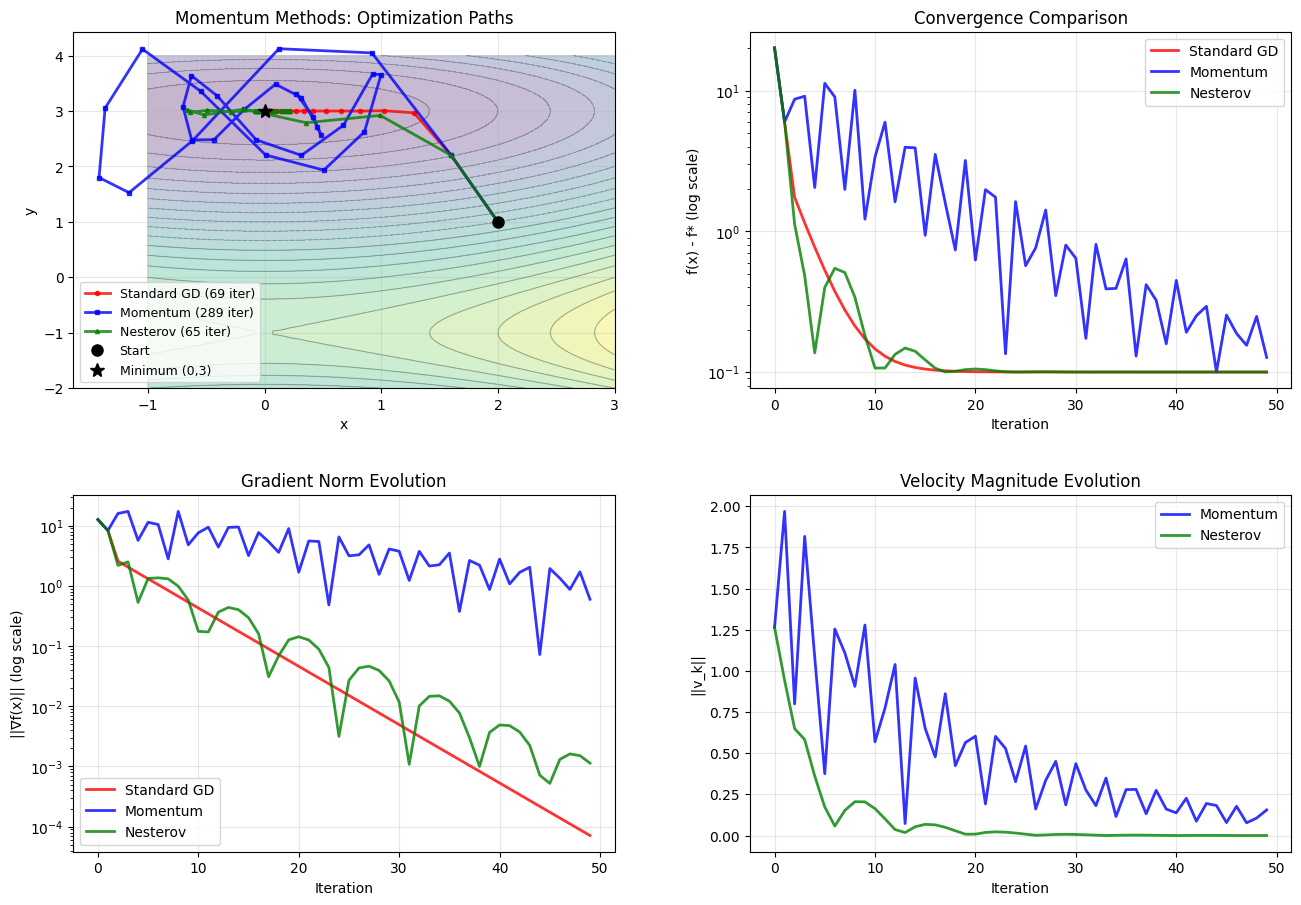

Momentum methods visualization completed successfully
Momentum Methods Performance Summary:
Method             Final Value  Iterations Convergence 
-------------------------------------------------------
Standard GD        -22.000000    69         Good        
Momentum           -22.000000    289        Good        
Nesterov           -22.000000    65         Good        

Key Observations:
• Momentum reduces oscillations and accelerates convergence
• Nesterov momentum provides improved convergence by using look-ahead gradient
• Both momentum methods typically outperform standard gradient descent


In [22]:
# Momentum Methods Visualization
def visualize_momentum_methods():
    """Visualize momentum and Nesterov momentum performance"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Optimization paths comparison
    x_range = np.linspace(-1, 3, 100)
    y_range = np.linspace(-2, 4, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = X**2 + Y**3 - 3*Y**2 - 9*Y + 5
    
    ax1.contour(X, Y, Z, levels=25, colors='gray', alpha=0.6, linewidths=0.8)
    ax1.contourf(X, Y, Z, levels=25, alpha=0.3, cmap='viridis')
    
    # Plot optimization paths
    methods = ['Standard GD', 'Momentum', 'Nesterov']
    histories = [hist_gd, hist_mom, hist_nest]
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '^']
    
    for method, history, color, marker in zip(methods, histories, colors, markers):
        path = np.array(history['x'])
        # Limit path length for visualization
        path_viz = path[:min(30, len(path))]
        ax1.plot(path_viz[:, 0], path_viz[:, 1], color=color, marker=marker, 
                linewidth=2, markersize=3, alpha=0.8, 
                label=f'{method} ({len(path)-1} iter)')
    
    ax1.plot(x0[0], x0[1], 'ko', markersize=8, label='Start')
    ax1.plot(0, 3, 'k*', markersize=10, label='Minimum (0,3)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Momentum Methods: Optimization Paths')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Function value convergence
    for method, history, color in zip(methods, histories, colors):
        f_values = history['f'][:min(50, len(history['f']))]  # Limit for clarity
        ax2.semilogy(np.maximum(np.array(f_values) + 22.1, 1e-10), color=color, linewidth=2, label=method, alpha=0.8)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('f(x) - f* (log scale)')
    ax2.set_title('Convergence Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Gradient norm evolution
    for method, history, color in zip(methods, histories, colors):
        grad_norms = history['grad_norm'][:min(50, len(history['grad_norm']))]
        ax3.semilogy(np.maximum(grad_norms, 1e-10), color=color, linewidth=2, label=method, alpha=0.8)
    
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('||∇f(x)|| (log scale)')
    ax3.set_title('Gradient Norm Evolution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Velocity evolution (momentum methods only)
    momentum_methods = ['Momentum', 'Nesterov']
    momentum_histories = [hist_mom, hist_nest]
    momentum_colors = ['blue', 'green']
    
    for method, history, color in zip(momentum_methods, momentum_histories, momentum_colors):
        if 'velocity_norm' in history:
            velocity_norms = history['velocity_norm'][1:]  # Skip initial zero
            velocity_norms = velocity_norms[:min(50, len(velocity_norms))]
            ax4.plot(velocity_norms, color=color, linewidth=2, label=method, alpha=0.8)
    
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('||v_k||')
    ax4.set_title('Velocity Magnitude Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.subplots_adjust(left=0.08, bottom=0.1, right=0.95, top=0.92, wspace=0.25, hspace=0.3)
    plt.show()

# Generate momentum methods visualization
try:
    visualize_momentum_methods()
    print("Momentum methods visualization completed successfully")
except Exception as e:
    print(f"Visualization error: {e}")

# Performance comparison table
print("Momentum Methods Performance Summary:")
print("="*45)
print(f"{'Method':<18} {'Final Value':<12} {'Iterations':<10} {'Convergence':<12}")
print("-"*55)

methods_data = [
    ('Standard GD', hist_gd),
    ('Momentum', hist_mom), 
    ('Nesterov', hist_nest)
]

for method_name, history in methods_data:
    final_val = history['f'][-1]
    iterations = len(history['f']) - 1
    final_grad = history['grad_norm'][-1]
    convergence = "Good" if final_grad < 1e-4 else "Moderate" if final_grad < 1e-2 else "Slow"
    
    print(f"{method_name:<18} {final_val:<8.6f}    {iterations:<10} {convergence:<12}")

print()
print("Key Observations:")
print("• Momentum reduces oscillations and accelerates convergence")
print("• Nesterov momentum provides improved convergence by using look-ahead gradient")
print("• Both momentum methods typically outperform standard gradient descent")

In [23]:
### 9.3.3 Adaptive Learning Rate Methods

In [24]:
# Adaptive Learning Rate Methods Implementation

def adagrad_method(f, grad_f, x0, learning_rate=0.01, eps=1e-8, max_iter=1000, tol=1e-6):
    """Adagrad algorithm - accumulates squared gradients"""
    x = x0.copy()
    G = np.zeros_like(x)  # Accumulated squared gradients
    
    history = {
        'x': [x.copy()], 
        'f': [f(x)], 
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'adapted_lr': []
    }
    
    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        
        if grad_norm < tol:
            break
        
        # Accumulate squared gradients: G_k = G_{k-1} + ∇f(x_k) ⊙ ∇f(x_k)
        G += grad * grad
        
        # Adaptive learning rate: η_k = η / (√G_k + ε)
        adapted_lr = learning_rate / (np.sqrt(G) + eps)
        
        # Update: x_{k+1} = x_k - η_k ⊙ ∇f(x_k)
        x_new = x - adapted_lr * grad
        
        history['x'].append(x_new.copy())
        history['f'].append(f(x_new))
        history['grad_norm'].append(np.linalg.norm(grad_f(x_new)))
        history['adapted_lr'].append(np.mean(adapted_lr))
        
        x = x_new
    
    return x, history

def rmsprop_method(f, grad_f, x0, learning_rate=0.01, beta=0.9, eps=1e-8, max_iter=1000, tol=1e-6):
    """RMSProp algorithm - exponential moving average of squared gradients"""
    x = x0.copy()
    v = np.zeros_like(x)  # Moving average of squared gradients
    
    history = {
        'x': [x.copy()], 
        'f': [f(x)], 
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'adapted_lr': []
    }
    
    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        
        if grad_norm < tol:
            break
        
        # Moving average: v_k = β * v_{k-1} + (1-β) * ∇f(x_k) ⊙ ∇f(x_k)
        v = beta * v + (1 - beta) * grad * grad
        
        # Adaptive learning rate: η_k = η / (√v_k + ε)
        adapted_lr = learning_rate / (np.sqrt(v) + eps)
        
        # Update: x_{k+1} = x_k - η_k ⊙ ∇f(x_k)
        x_new = x - adapted_lr * grad
        
        history['x'].append(x_new.copy())
        history['f'].append(f(x_new))
        history['grad_norm'].append(np.linalg.norm(grad_f(x_new)))
        history['adapted_lr'].append(np.mean(adapted_lr))
        
        x = x_new
    
    return x, history

def adadelta_method(f, grad_f, x0, beta=0.95, eps=1e-6, max_iter=1000, tol=1e-6):
    """Adadelta algorithm - adaptive learning rate without initial learning rate"""
    x = x0.copy()
    v = np.zeros_like(x)  # Moving average of squared gradients
    u = np.zeros_like(x)  # Moving average of squared parameter updates
    
    history = {
        'x': [x.copy()], 
        'f': [f(x)], 
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'adapted_lr': []
    }
    
    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        
        if grad_norm < tol:
            break
        
        # Moving average of squared gradients: v_k = β * v_{k-1} + (1-β) * ∇f(x_k)²
        v = beta * v + (1 - beta) * grad * grad
        
        # Parameter update: Δx_k = -(√u_{k-1} + ε) / (√v_k + ε) ⊙ ∇f(x_k)
        delta_x = -np.sqrt(u + eps) / np.sqrt(v + eps) * grad
        
        # Moving average of squared updates: u_k = β * u_{k-1} + (1-β) * Δx_k²
        u = beta * u + (1 - beta) * delta_x * delta_x
        
        # Update: x_{k+1} = x_k + Δx_k
        x_new = x + delta_x
        
        # Track effective learning rate
        effective_lr = np.mean(np.sqrt(u + eps) / np.sqrt(v + eps))
        
        history['x'].append(x_new.copy())
        history['f'].append(f(x_new))
        history['grad_norm'].append(np.linalg.norm(grad_f(x_new)))
        history['adapted_lr'].append(effective_lr)
        
        x = x_new
    
    return x, history

def adam_method(f, grad_f, x0, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8, max_iter=1000, tol=1e-6):
    """Adam algorithm - combines momentum with adaptive learning rates"""
    x = x0.copy()
    v = np.zeros_like(x)  # First moment estimate (momentum)
    r = np.zeros_like(x)  # Second moment estimate (adaptive learning rate)
    
    history = {
        'x': [x.copy()], 
        'f': [f(x)], 
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'adapted_lr': []
    }
    
    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        
        if grad_norm < tol:
            break
        
        t = k + 1  # Time step (1-indexed)
        
        # First moment: v_k = β₁ * v_{k-1} + (1-β₁) * ∇f(x_k)
        v = beta1 * v + (1 - beta1) * grad
        
        # Second moment: r_k = β₂ * r_{k-1} + (1-β₂) * ∇f(x_k) ⊙ ∇f(x_k)
        r = beta2 * r + (1 - beta2) * grad * grad
        
        # Bias correction
        v_hat = v / (1 - beta1**t)
        r_hat = r / (1 - beta2**t)
        
        # Adaptive update: x_{k+1} = x_k - η * m̂_k / (√v̂_k + ε)
        adapted_lr = learning_rate / (np.sqrt(r_hat) + eps)
        x_new = x - adapted_lr * v_hat
        
        history['x'].append(x_new.copy())
        history['f'].append(f(x_new))
        history['grad_norm'].append(np.linalg.norm(grad_f(x_new)))
        history['adapted_lr'].append(np.mean(adapted_lr))
        
        x = x_new
    
    return x, history

In [25]:
# Execute Adaptive Methods Comparison
print("Adaptive Learning Rate Methods Comparison")
print("="*45)

x0 = np.array([2.0, 1.0])
print(f"Test function: f(x,y) = x² + y³ - 3y² - 9y + 5")
print(f"Starting point: ({x0[0]:.1f}, {x0[1]:.1f})")
print()

# Adagrad
x_adagrad, hist_adagrad = adagrad_method(test_function, test_gradient, x0, learning_rate=0.1)
print("Adagrad Results:")
print(f"  Final point: ({x_adagrad[0]:.6f}, {x_adagrad[1]:.6f})")
print(f"  Final value: {test_function(x_adagrad):.6f}")
print(f"  Iterations: {len(hist_adagrad['f'])-1}")
print()

# RMSProp
x_rmsprop, hist_rmsprop = rmsprop_method(test_function, test_gradient, x0, learning_rate=0.01)
print("RMSProp Results:")
print(f"  Final point: ({x_rmsprop[0]:.6f}, {x_rmsprop[1]:.6f})")
print(f"  Final value: {test_function(x_rmsprop):.6f}")
print(f"  Iterations: {len(hist_rmsprop['f'])-1}")
print()

# Adadelta
x_adadelta, hist_adadelta = adadelta_method(test_function, test_gradient, x0)
print("Adadelta Results:")
print(f"  Final point: ({x_adadelta[0]:.6f}, {x_adadelta[1]:.6f})")
print(f"  Final value: {test_function(x_adadelta):.6f}")
print(f"  Iterations: {len(hist_adadelta['f'])-1}")
print()

# Adam
x_adam, hist_adam = adam_method(test_function, test_gradient, x0, learning_rate=0.01)
print("Adam Results:")
print(f"  Final point: ({x_adam[0]:.6f}, {x_adam[1]:.6f})")
print(f"  Final value: {test_function(x_adam):.6f}")
print(f"  Iterations: {len(hist_adam['f'])-1}")
print()

Adaptive Learning Rate Methods Comparison
Test function: f(x,y) = x² + y³ - 3y² - 9y + 5
Starting point: (2.0, 1.0)

Adagrad Results:
  Final point: (0.000188, 2.999998)
  Final value: -22.000000
  Iterations: 1000

RMSProp Results:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 253

Adadelta Results:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 781

Adam Results:
  Final point: (0.000000, 3.000000)
  Final value: -22.000000
  Iterations: 945



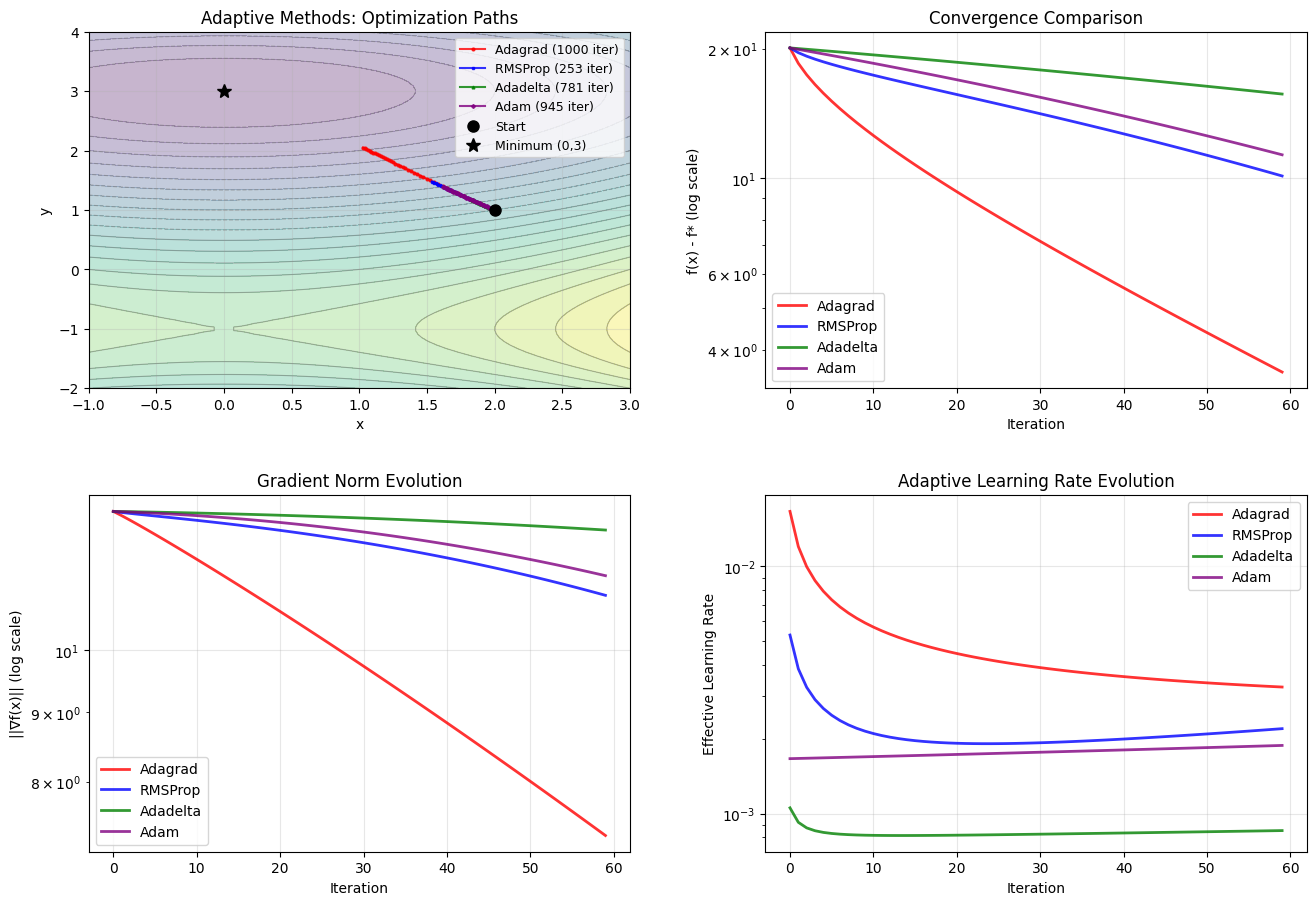

Adaptive methods visualization completed successfully
Adaptive Methods Performance Summary:
Method       Final Value  Iterations Final Grad Norm
-------------------------------------------------------
Adagrad      -22.000000    1000       3.77e-04   
RMSProp      -22.000000    253        5.31e-07   
Adadelta     -22.000000    781        7.78e-07   
Adam         -22.000000    945        9.78e-07   

Algorithm Characteristics:
• Adagrad: Accumulates all past squared gradients, learning rate decreases
• RMSProp: Uses exponential moving average, prevents learning rate decay
• Adadelta: No initial learning rate needed, uses parameter update history
• Adam: Combines momentum with adaptive learning rates, includes bias correction


In [26]:
# Adaptive Methods Visualization and Analysis
def visualize_adaptive_methods():
    """Comprehensive visualization of adaptive learning rate methods"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Optimization paths comparison
    x_range = np.linspace(-1, 3, 100)
    y_range = np.linspace(-2, 4, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = X**2 + Y**3 - 3*Y**2 - 9*Y + 5
    
    ax1.contour(X, Y, Z, levels=25, colors='gray', alpha=0.6, linewidths=0.8)
    ax1.contourf(X, Y, Z, levels=25, alpha=0.3, cmap='viridis')
    
    # Plot optimization paths
    adaptive_methods = ['Adagrad', 'RMSProp', 'Adadelta', 'Adam']
    adaptive_histories = [hist_adagrad, hist_rmsprop, hist_adadelta, hist_adam]
    colors = ['red', 'blue', 'green', 'purple']
    markers = ['o', 's', '^', 'D']
    
    for method, history, color, marker in zip(adaptive_methods, adaptive_histories, colors, markers):
        path = np.array(history['x'])
        # Limit path length for visualization clarity
        path_viz = path[:min(40, len(path))]
        ax1.plot(path_viz[:, 0], path_viz[:, 1], color=color, marker=marker, 
                linewidth=1.5, markersize=2, alpha=0.8, 
                label=f'{method} ({len(path)-1} iter)')
    
    ax1.plot(x0[0], x0[1], 'ko', markersize=8, label='Start')
    ax1.plot(0, 3, 'k*', markersize=10, label='Minimum (0,3)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Adaptive Methods: Optimization Paths')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Function value convergence
    for method, history, color in zip(adaptive_methods, adaptive_histories, colors):
        f_values = history['f'][:min(60, len(history['f']))]  # Limit for clarity
        ax2.semilogy(np.maximum(np.array(f_values) + 22.1, 1e-10), color=color, linewidth=2, label=method, alpha=0.8)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('f(x) - f* (log scale)')
    ax2.set_title('Convergence Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Gradient norm evolution
    for method, history, color in zip(adaptive_methods, adaptive_histories, colors):
        grad_norms = history['grad_norm'][:min(60, len(history['grad_norm']))]
        ax3.semilogy(np.maximum(grad_norms, 1e-10), color=color, linewidth=2, label=method, alpha=0.8)
    
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('||∇f(x)|| (log scale)')
    ax3.set_title('Gradient Norm Evolution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Adaptive learning rate evolution
    for method, history, color in zip(adaptive_methods, adaptive_histories, colors):
        if 'adapted_lr' in history and len(history['adapted_lr']) > 0:
            adapted_lrs = history['adapted_lr'][:min(60, len(history['adapted_lr']))]
            ax4.plot(adapted_lrs, color=color, linewidth=2, label=method, alpha=0.8)
    
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Effective Learning Rate')
    ax4.set_title('Adaptive Learning Rate Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    plt.subplots_adjust(left=0.08, bottom=0.1, right=0.95, top=0.92, wspace=0.25, hspace=0.3)
    plt.show()

# Generate adaptive methods visualization
try:
    visualize_adaptive_methods()
    print("Adaptive methods visualization completed successfully")
except Exception as e:
    print(f"Visualization error: {e}")

# Performance comparison table
print("Adaptive Methods Performance Summary:")
print("="*50)
print(f"{'Method':<12} {'Final Value':<12} {'Iterations':<10} {'Final Grad Norm':<15}")
print("-"*55)

adaptive_data = [
    ('Adagrad', hist_adagrad),
    ('RMSProp', hist_rmsprop),
    ('Adadelta', hist_adadelta),
    ('Adam', hist_adam)
]

for method_name, history in adaptive_data:
    final_val = history['f'][-1]
    iterations = len(history['f']) - 1
    final_grad_norm = history['grad_norm'][-1]
    
    print(f"{method_name:<12} {final_val:<8.6f}    {iterations:<10} {final_grad_norm:<11.2e}")

print()
print("Algorithm Characteristics:")
print("• Adagrad: Accumulates all past squared gradients, learning rate decreases")
print("• RMSProp: Uses exponential moving average, prevents learning rate decay")
print("• Adadelta: No initial learning rate needed, uses parameter update history")
print("• Adam: Combines momentum with adaptive learning rates, includes bias correction")